In [1]:
import os
import keras
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.api.models import load_model, Sequential
from keras.api.layers import Dense, Flatten, Dropout
from keras.api.optimizers import Adam
from keras.api.losses import SparseCategoricalCrossentropy
from keras import layers, activations, Model
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

2024-11-02 17:02:05.750874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 17:02:05.765595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 17:02:05.769717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 17:02:05.779581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 17:02:06.585077: W tensorflow/compiler/tf2

In [2]:
CHECKPOINTS = "checkpoints"
CLASS_ARR = ["Colon polyps", "Colorectal cancer", "Normal mucosa and vascular pattern in the large bowel"]

In [3]:
def make_evaluation_metrics(model: Model, validation_dataset: tf.data.Dataset):
    predictions = np.array([])
    labels = np.array([])
    categories = CLASS_ARR

    for x, y in validation_dataset:
        y_pred = model.predict(x)
        y_prediction = np.argmax(y_pred, axis=1)
        predictions = np.concatenate([predictions, y_prediction])
        labels = np.concatenate([labels, y.numpy()])

    print("---------------EVALUATION METRICS---------------")

    print(f"Accuracy Score:     {accuracy_score(y_true=labels, y_pred=predictions)}")
    print(f"Precision Score:    {precision_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"Recall Score:       {recall_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"F1 Score:           {f1_score(y_true=labels, y_pred=predictions, average=None)}")

    print("----------------CONFUSION MATRIX----------------")

    plt.figure(num=69420, figsize=(plt.rcParams.get('figure.figsize')))
    sns.heatmap(confusion_matrix(y_true=labels, y_pred=predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt="d")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

    print("-------------END EVALUATION METRICS-------------")

In [4]:
# Save the current model
def save_model(model, model_name: str = ""):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + ".keras")
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e

In [5]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 224
img_width   = 224
channel     = 3

image_size              = (img_height, img_width)
image_size_with_channel = (img_height, img_width, channel)

# Constant value
CHECKPOINTS = "checkpoints"
LATEST_MODEL_NAME = "_latest_model.keras"

In [6]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_Gastrovision/training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_Gastrovision/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1942 files belonging to 3 classes.


I0000 00:00:1730541736.101405   43309 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541736.134916   43309 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541736.135105   43309 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541736.136392   43309 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 484 files belonging to 3 classes.


In [7]:
image_augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.2),
        layers.RandomFlip()
    ])
}

In [8]:
resnet_model = keras.applications.ResNet50(
    include_top=False,
    classes=3,
    input_shape=(img_height, img_width, channel)
)

In [9]:
resnet_model.trainable = False

# un-freeze some of the last layers
for layer in resnet_model.layers[-10:]:
     layer.trainable = True

In [10]:
inputs = keras.Input(shape=image_size_with_channel)
x = image_augmentation["training"](inputs)
x = keras.applications.resnet.preprocess_input(x)
x = resnet_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64)(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation=activations.softmax)(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0] 

 Total params: 24,155,395 (92.15 MB)

 Trainable params: 5,032,451 (19.20 MB)

 Non-trainable params: 19,122,944 (72.95 MB)

In [11]:
def get_early_stopping():
    return keras.callbacks.EarlyStopping(patience=5)

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [13]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[get_early_stopping()])

Epoch 1/10


2024-11-02 17:02:38.192334: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730541758.254630   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541758.290720   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541758.295367   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541758.300991   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541758.306553   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541758.318985   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541758.330158   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541758.341050   43452 gpu_t

 1/61 ━━━━━━━━━━━━━━━━━━━━ 12:36 13s/step - accuracy: 0.3750 - loss: 1.7242

W0000 00:00:1730541761.103450   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541761.108200   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541761.112534   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541761.118677   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541761.124077   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541761.129555   43452 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4313 - loss: 1.6877

W0000 00:00:1730541773.611277   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.614324   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.617200   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.620602   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.624084   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.629301   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.635891   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.641571   43445 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541773.648417   43445 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4324 - loss: 1.6842

W0000 00:00:1730541775.256495   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541775.260936   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541775.265265   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541775.269817   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541779.967811   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541779.969337   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541779.970862   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541779.972530   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541779.974113   43449 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 325ms/step - accuracy: 0.4334 - loss: 1.6809 - val_accuracy: 0.6632 - val_loss: 1.3744
Epoch 2/10


W0000 00:00:1730541780.584035   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.585363   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.586766   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.588219   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.590027   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.591474   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.592843   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.594224   43449 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730541780.595668   43449 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.6284 - loss: 1.0869 - val_accuracy: 0.6570 - val_loss: 1.6698
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.6909 - loss: 0.8632 - val_accuracy: 0.7707 - val_loss: 0.8100
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.7295 - loss: 0.7844 - val_accuracy: 0.8161 - val_loss: 0.6233
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.7652 - loss: 0.6372 - val_accuracy: 0.8306 - val_loss: 0.4980
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.7900 - loss: 0.6595 - val_accuracy: 0.8326 - val_loss: 0.4889
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.8119 - loss: 0.5744 - val_accuracy: 0.8430 - val_loss: 0.5435
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.8313 - loss: 0.4887 - val_accuracy: 0.8326 - val_loss: 0.5766
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.8452 - loss: 0.5111 - val_accuracy: 0.859

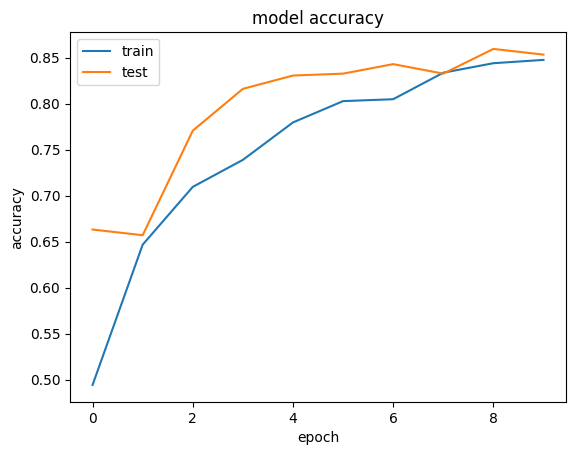

In [14]:
# show training accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

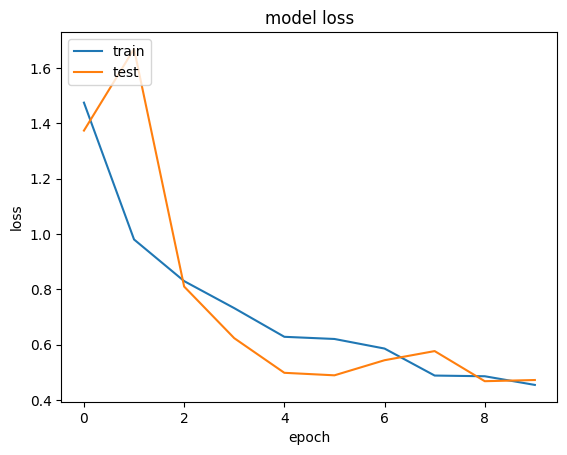

In [15]:
# show training loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# save_model(model, "resnet_50_feature-extraction")
save_model(model, "resnet_50_transfer-learning")

Model has succesfully saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
---------------EVALUATION METRICS---------------
Accuracy Score:     0.8533057851239669
Precision Score:    [0.84397163 0.80952381 0.86024845]
Recall Score:       [0.72560976 0.62962963 0.94539249]
F1 Score:           [0.78032787 0.70833333 0.90081301]
----------------CONFUSION MATRIX----------------


2024-11-02 17:07:03.724582: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


-------------END EVALUATION METRICS-------------


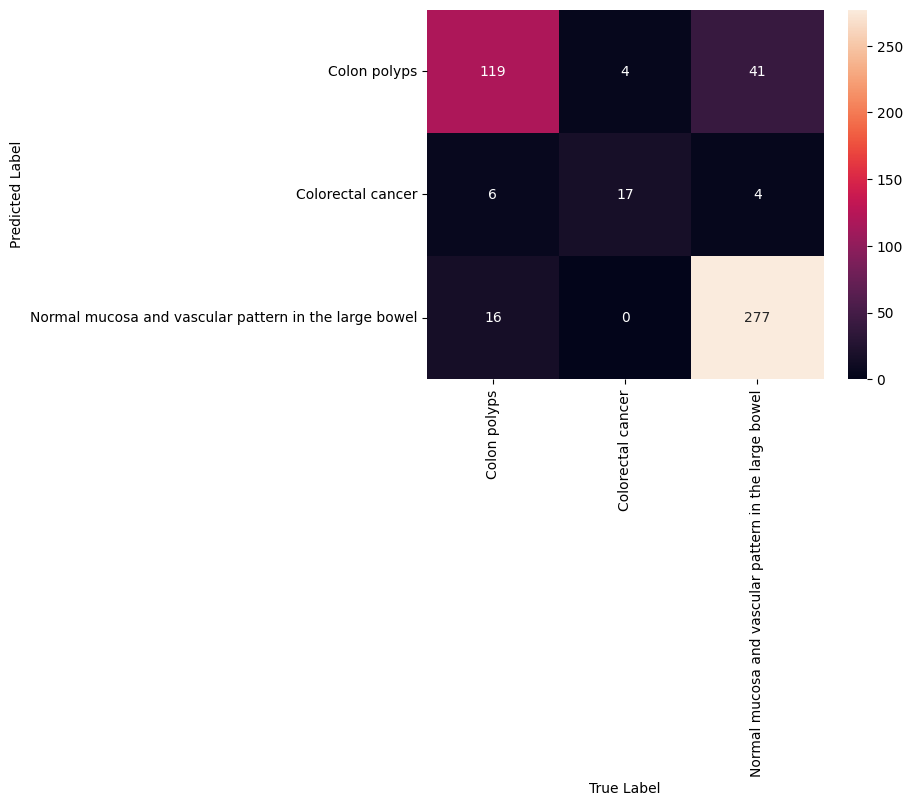

In [17]:
make_evaluation_metrics(model, val_ds)